In [27]:
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
import time
from pathlib import Path


**Load datasets**

In [28]:
DATA_DIR = Path('C:/Users/PMAgbayani/Desktop/heart')

In [29]:
train_values = pd.read_csv(DATA_DIR / 'train_values.csv', index_col='patient_id')
train_labels = pd.read_csv(DATA_DIR / 'train_labels.csv', index_col='patient_id')

In [2]:
train= pd.read_csv("C://Users/PMAgbayani/Desktop/heart/train_values.csv")
labels=pd.read_csv("C://Users/PMAgbayani/Desktop/heart/train_labels.csv")
test=pd.read_csv("C://Users/PMAgbayani/Desktop/heart/test_values.csv")
train.shape, labels.shape

((180, 14), (180, 2))

**Merging labels with train features to get better understanding of data and dropping patient_id**

In [3]:
labels.drop('patient_id', axis=1, inplace=True)
df= pd.concat([train, labels], axis=1)
df.drop(['patient_id'], axis=1, inplace=True)

df.head()

,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
0,1,normal,128,2,0,0,2,308,0.0,1,45,170,0,0
1,2,normal,110,3,0,0,0,214,1.6,0,54,158,0,0
2,1,normal,125,4,3,0,2,304,0.0,1,77,162,1,1
3,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0,1
4,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0,0


**Let's visualize frequencies of target label**

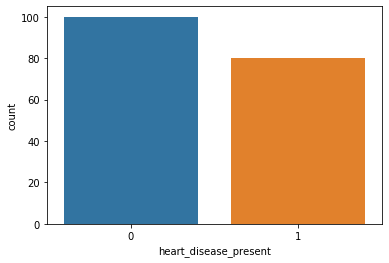

In [4]:
sns.countplot(df['heart_disease_present'])

**Converting thal categorical variable into numeric form**

In [5]:
df['thal']=df['thal'].map({'normal':1,'reversible_defect':2, 'fixed_defect':3 })

**Storing predictors and target into arrays to feed them into model**

In [6]:
y=np.asarray(df['heart_disease_present'])
df.drop(['heart_disease_present'], axis=1, inplace=True)
x=np.asarray(df)

**Splitting dataset into two halves, train and test set**

* `test_size` defines size of test set

In [30]:
selected_features = ['age', 
                     'sex', 
                     'max_heart_rate_achieved', 
                     'resting_blood_pressure']
train_values_subset = train_values[selected_features]

In [31]:
X = train_values_subset
y = train_labels.heart_disease_present
xtrain, xtest, ytrain, ytest= train_test_split(x, y, test_size=0.2, random_state=4)

### Model Building

* Model building using `RandomForestClassifier`
* Using `GridSearchCV` to make process of finding best `hyperparameters` simpler (but it takes more time as you increase size of hyperparameters)

In [8]:
ts= time.time()

parameter=[{'max_features':[2,3,4],
            'min_samples_leaf':[1,2]}]

RF= RandomForestClassifier(n_jobs=-1,n_estimators=100, random_state=1024,oob_score=False)

grid=GridSearchCV(RF, parameter, cv=10)

grid.fit(xtrain, ytrain)

print("Best score of Ridge: ",grid.best_score_ )

print("\nIt took",np.round((time.time()-ts)/60,3),"minutes to run." )

c:\users\pmagbayani\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best score of Ridge:  0.8541666666666666

It took 3.901 minutes to run.


`best_estimator` to find what parameters produced best results

In [9]:
grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1024, verbose=0,
                       warm_start=False)

**Evaluation of model using In-Sample(data model trained on) and Out-Sample(data model never seen before) data**

In [10]:
predict1= grid.predict_proba(xtrain)
print("\nOut-Sample logloss: ",np.round(log_loss(ytrain, predict1),4))

predict2= grid.predict_proba(xtest)
print("\nOut-Sample Logloss: ",np.round(log_loss(ytest, predict2),4))


Out-Sample logloss:  0.1175

Out-Sample Logloss:  0.4522


Looks well! Let's move to predict test data of competition and see where we stand on leaderboard.

### Make predictions on Test dataset of Competition

In [11]:
idd= test['patient_id']
test['thal']=test['thal'].map({'normal':1,'reversible_defect':2, 'fixed_defect':3 })
test.drop(['patient_id'], axis=1, inplace=True)
xx=np.asarray(test)

In [12]:
predictions= grid.predict_proba(xx)
pred= predictions[:,1]

Storing predictions in a csv file

In [13]:
data= pd.DataFrame({'patient_id':idd, 'heart_disease_present':pred})
data.to_csv("submit2.csv", index=False)

In [14]:
data.head()

,patient_id,heart_disease_present
0,olalu7,0.32
1,z9n6mx,0.24
2,5k4413,0.96
3,mrg7q5,0.24
4,uki4do,0.91


In [17]:
import datetime
from sklearn import datasets, metrics, tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import validation_curve

In [32]:
estimator = RandomForestRegressor(random_state=0)
param_range = np.arange(0.1,30.1,0.1)
param_name = "max_depth"
cv = 5
n_jobs = 30

X = train_values_subset
y = train_labels.heart_disease_present


a = datetime.datetime.now()
train_scores, test_scores = validation_curve(estimator, X, y, param_name=param_name, param_range=param_range,cv=cv, n_jobs=n_jobs)
b = datetime.datetime.now()

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

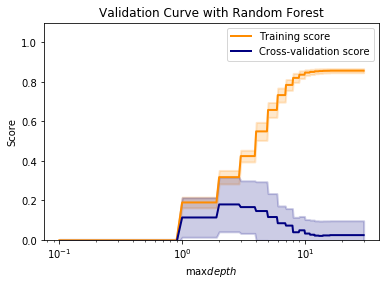

The maximum training R-squared score is  0.856595718680054
The maximum cross-validation R-squared score is  0.856595718680054
The elapsed time is  0:02:47.933495


In [34]:
plt.title("Validation Curve with Random Forest")
plt.xlabel("$\max depth$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.2,color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.2,color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

print ('The maximum training R-squared score is ', max(train_scores_mean))
print ('The maximum cross-validation R-squared score is ', max(train_scores_mean)) ## error-> must be test_scores_mean
print ('The elapsed time is ', (b-a))


In [35]:
from sklearn.model_selection import learning_curve

In [36]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    a = datetime.datetime.now()
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    b = datetime.datetime.now()
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes,train_scores_mean-train_scores_std,train_scores_mean+train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes,test_scores_mean-test_scores_std,test_scores_mean+test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes,train_scores_mean,'o-',color='r',label='Training score')
    plt.plot(train_sizes,test_scores_mean,'o-',color='g',label='Cross-validation score')
    plt.legend(loc='best')
    
    print('The maximum training score mean is ', max(train_scores_mean))
    print('The maximum cross-validation score mean is ', max(test_scores_mean))
    print('The maximum training score is ', max(train_scores[0]))
    print('The maximum cross-validation score is ', max(test_scores[0]))
    print('The elapsed time is ', (b-a))
    
    return plt

The maximum training score mean is  0.67546351440235
The maximum cross-validation score mean is  0.16575238263534656
The maximum training score is  0.9114285714285714
The maximum cross-validation score is  0.11550068587105633
The elapsed time is  0:04:29.370458


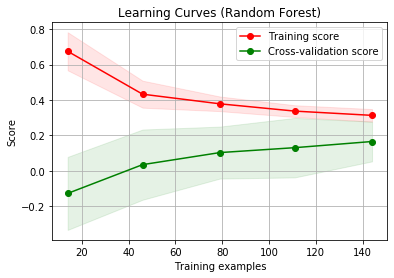

In [37]:
from sklearn.model_selection import ShuffleSplit

# Cross validation with n iterations to get smoother mean test and train scores, 
# each time with 20% data randomly selected as validation set. 
n = 10
cv = ShuffleSplit(n_splits=n, test_size=0.2, random_state=0)
estimator = RandomForestRegressor(max_depth=2)
title = "Learning Curves (Random Forest)"
n_jobs=50
plot_learning_curve(estimator,title,X,y,cv=cv,n_jobs=n_jobs)
plt.show()